---
title: Dataset Cross Tests and Primary Component Analysis
author: Andrei Akopian
date: 2026-01-31
format:
  html:
    code-fold: true
    code-summary: "Show the code"
  pdf:
    code-overflow: wrap
    echo: false
    output: true
---

In [1]:
import pandas as pd
import numpy as np
import spectral_library # * all major functions have been moved here
import matplotlib.pyplot as plt
import scipy
from icecream import ic
import mpltern
import sklearn
from sklearn.decomposition import PCA, TruncatedSVD

In [2]:
df = spectral_library.open_file('unmixing/original_data.csv')

In [3]:
fractions, nr400to2490, _ = spectral_library.take_subset(df,start=400,end=2490)
_, nr900to1700, _ = spectral_library.take_subset(df,start=900,end=1700)
source_fields = list(set(df['reference_for_original_field_spectra']))

In [4]:
source_fields

['Quemada, M.; Daughtry, C.S.T. Spectral Indices to Improve Crop Residue Cover Estimation under Varying Moisture Conditions. Remote Sensing 2016, 8, 660. https://doi.org/10.3390/rs8080660.',
 'Roberts, D.; Brown, K.; Green, R.; Ustin, S.; Hinckley, T. Investigating the Relationship Between Liquid Water and Leaf Area in Clonal Populus. In Proceedings of the Summaries of the Seventh JPL Airborne Earth Science Workshop; Jet Propulsion Lab: Pasadena, 1998.',
 nan,
 'Numata, I.; Roberts, D.A.; Chadwick, O.A.; Schimel, J.P.; Galvão, L.S.; Soares, J.V. Evaluation of hyperspectral data for pasture estimate in the Brazilian Amazon using field and imaging spectrometers. Remote Sensing of Environment 2008, 112, 1569–1583. https://doi.org/10.1016/j.rse.2007.08.014.',
 'Roth, K. Discriminating Among Plant Species and Functional Types Using Spectroscopy Data: Evaluating Capabilities Within and Across Ecosystems, Across Spatial Scales and Through Seasons, University of California Santa Barbara, 2014.

In [5]:
source_separated_dataframes = {
    field[:4] : [
        nr900to1700[df['reference_for_original_field_spectra'] == field],
        fractions[df['reference_for_original_field_spectra'] == field]
    ]
    for field in source_fields if isinstance(field, str)
}
# add unnamed dataset in
source_separated_dataframes['unna'] = [
    nr900to1700[pd.isna(df['reference_for_original_field_spectra'])],
    fractions[pd.isna(df['reference_for_original_field_spectra'])],
]

for frame_name in source_separated_dataframes:
    print(frame_name, source_separated_dataframes[frame_name][0].shape[0])
print("Total:", sum([source_separated_dataframes[frame_name][0].shape[0] for frame_name in source_separated_dataframes]))

Quem 316
Robe 24
Numa 60
Roth 595
Daug 599
unna 129
Total: 1723


In [6]:
all_spectra = {
    'Quem',
    'Roth',
    'Numa',
    'Robe',
    'Daug',
    'unna',
}

train_spectra = {
    # 'Quem', # 316
    'Roth', # 595
    'Numa', # 60
    'Robe', # 24
    # 'Daug', # 599
    # 'unna', # 129
}

train_X = pd.concat([
    source_separated_dataframes[frame_name][0]
    for frame_name in train_spectra
])
train_y = pd.concat([
    source_separated_dataframes[frame_name][1]
    for frame_name in train_spectra
])

test_X = pd.concat([
    source_separated_dataframes[frame_name][0]
    for frame_name in (all_spectra - train_spectra)
    # for frame_name in all_spectra
])
test_y = pd.concat([
    source_separated_dataframes[frame_name][1]
    for frame_name in (all_spectra - train_spectra)
    # for frame_name in all_spectra
])
def linearRegression(train_X,train_y,test_X,test_y):
    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X=train_X,y=train_y)
    return reg.score(X=test_X, y=test_y)

reg = sklearn.linear_model.LinearRegression()
reg.fit(X=train_X,y=train_y)
print("Training R^2:",round(reg.score(train_X,train_y),4))
for frame_name in (all_spectra - train_spectra):
    print(frame_name,"R^2:",round(reg.score(source_separated_dataframes[frame_name][0],source_separated_dataframes[frame_name][1]),4))

Training R^2: 0.6264
Quem R^2: -2.0092
Daug R^2: -0.5191
unna R^2: -2.8103


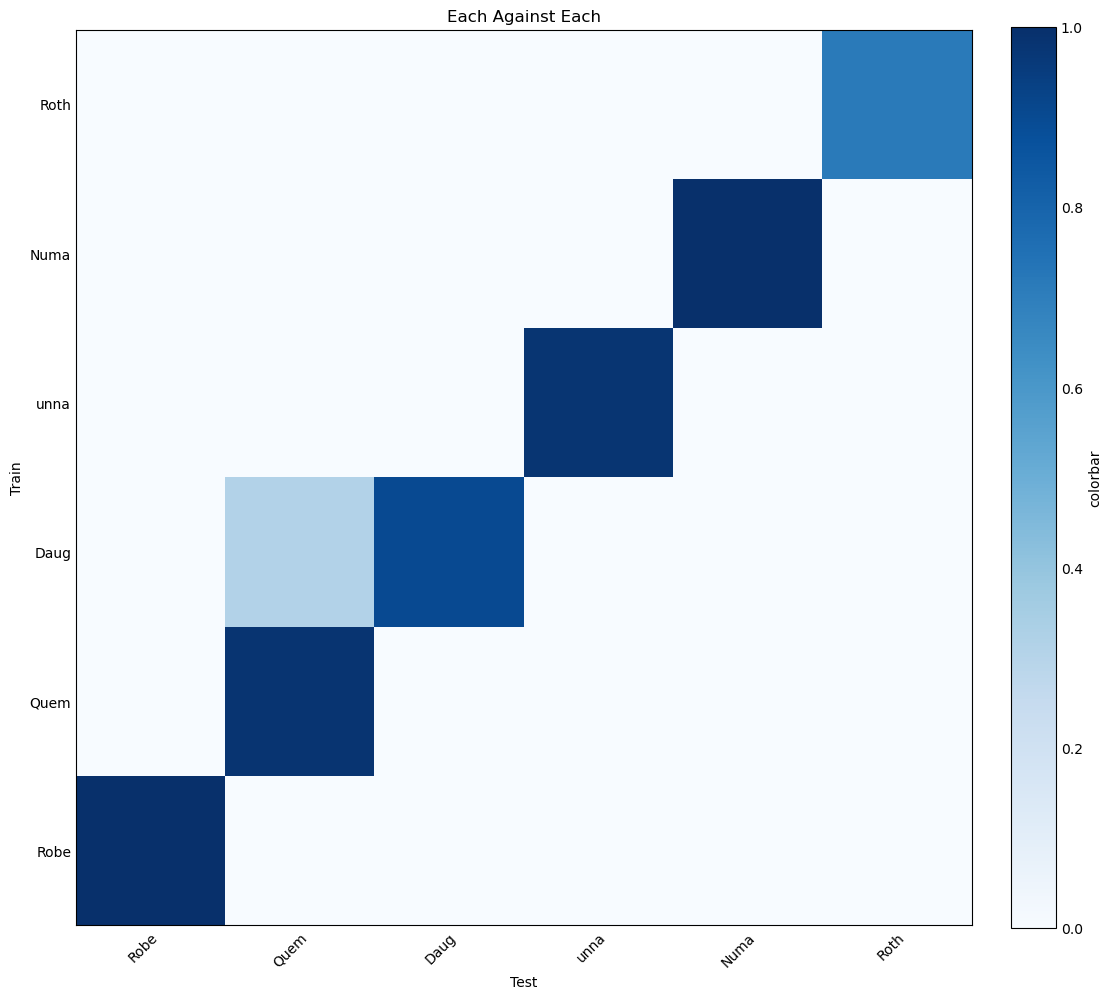

In [7]:
# each against each
matrix = [
    [
        np.clip(linearRegression(
            source_separated_dataframes[train][0],
            source_separated_dataframes[train][1],
            source_separated_dataframes[test][0],
            source_separated_dataframes[test][1],
        ), a_min=0, a_max=1)
        for test in all_spectra
    ]
    for train in all_spectra
]

spectral_library.plot_matrix(matrix, title="Each Against Each", x_labels=all_spectra, y_labels=all_spectra, xlabel="Test", ylabel="Train")

In [8]:
def powerset_binary(iterable):
    s = list(iterable)
    n = len(s)
    powerset_list = []
    # Iterate from 0 to 2^n - 1
    for i in range(2**n):
        subset = []
        # Check each bit in the binary representation of i
        for j in range(n):
            # If the j-th bit is set, add the j-th element
            if (i >> j) & 1:
                subset.append(s[j])
        powerset_list.append(tuple(subset)) # Using tuples for consistency
    return powerset_list

all_datasets = {
    'Quem',
    'Roth',
    'Numa',
    'Robe',
    'Daug',
    'unna',
}

for dataset in all_datasets:
    print(dataset, source_separated_dataframes[dataset][0].shape[0])
    for subset in powerset_binary(all_datasets - {dataset}):
        if len(subset)==0:
            continue
        train_X = pd.concat([
            source_separated_dataframes[frame_name][0]
            for frame_name in subset
        ])
        train_y = pd.concat([
            source_separated_dataframes[frame_name][1]
            for frame_name in subset
        ])
        score = linearRegression(
            train_X=train_X,
            train_y=train_y,
            test_X=source_separated_dataframes[dataset][0],
            test_y=source_separated_dataframes[dataset][1],
        )
        if score>0:
            print("\t",subset,f"r2={score}")

Robe 24
Quem 316
	 ('Daug',) r2=0.3107172016493448
	 ('Daug', 'Numa') r2=0.32481555197335465
	 ('unna', 'Daug', 'Numa') r2=0.09254643979581074
	 ('Daug', 'Roth') r2=0.2869335893468617
	 ('unna', 'Daug', 'Roth') r2=0.2138655527493977
	 ('Daug', 'Numa', 'Roth') r2=0.28934871527536055
	 ('unna', 'Daug', 'Numa', 'Roth') r2=0.22419308438900631
	 ('Daug', 'Robe') r2=0.3427647585370328
	 ('unna', 'Daug', 'Robe') r2=0.0771950775554379
	 ('Daug', 'Numa', 'Robe') r2=0.329549805497109
	 ('unna', 'Daug', 'Numa', 'Robe') r2=0.14434222658354975
	 ('Daug', 'Roth', 'Robe') r2=0.31647451907518315
	 ('unna', 'Daug', 'Roth', 'Robe') r2=0.2484814963568962
	 ('Daug', 'Numa', 'Roth', 'Robe') r2=0.31382798553519864
	 ('unna', 'Daug', 'Numa', 'Roth', 'Robe') r2=0.25455729609043315
Daug 599
	 ('Quem', 'Numa') r2=0.16186338803035386
	 ('Quem', 'unna', 'Numa') r2=0.33729383111336325
	 ('Quem', 'Roth') r2=0.43138817434613735
	 ('Quem', 'unna', 'Roth') r2=0.6506433954775707
	 ('Quem', 'Numa', 'Roth') r2=0.50525587

# Principal Component Analysis

Trying to perform princial component analysis. This should theoretically eliminate redundant spectra, and LinearRegerssion should start performing better.

In [91]:
TEST_SIZE = 0.5
N_COMPONENTS = 81

In [92]:
train_X, validate_X, train_y, validate_y = sklearn.model_selection.train_test_split(nr900to1700, fractions, test_size=TEST_SIZE, random_state=42)
svd = TruncatedSVD(n_components=N_COMPONENTS)
svd.fit(train_X)
print(svd.singular_values_)
train_X_reduced = svd.transform(train_X)
validate_X_reduced = svd.transform(validate_X)

[7.92302517e+01 1.38540916e+01 3.49244817e+00 2.42486759e+00
 2.29382216e+00 2.04858984e+00 1.86694660e+00 1.18678853e+00
 1.05746784e+00 7.26687482e-01 6.79153447e-01 4.46401047e-01
 3.71955864e-01 2.85112903e-01 2.30184839e-01 1.62418913e-01
 1.41520134e-01 1.32653901e-01 1.11076596e-01 8.68089747e-02
 6.85258167e-02 5.13444691e-02 4.73038789e-02 4.51775726e-02
 3.61050534e-02 3.17921347e-02 2.83956879e-02 2.57361737e-02
 2.19153444e-02 2.08419327e-02 2.05413281e-02 1.92991759e-02
 1.67327087e-02 1.60394834e-02 1.38236436e-02 1.33855899e-02
 1.21838755e-02 1.14175131e-02 1.06612878e-02 1.01069545e-02
 9.13283874e-03 8.98072576e-03 8.43527526e-03 8.07597434e-03
 7.95913566e-03 7.37957525e-03 7.00285320e-03 6.67284775e-03
 6.51769310e-03 6.45693876e-03 6.11098852e-03 5.98738304e-03
 5.64241127e-03 5.40552091e-03 5.31085184e-03 5.06950160e-03
 5.04672529e-03 4.85879473e-03 4.46826868e-03 4.31492221e-03
 4.14024459e-03 4.08328845e-03 4.01212233e-03 3.67443628e-03
 3.65848299e-03 3.566133

In [81]:
train_X, validate_X, train_y, validate_y = sklearn.model_selection.train_test_split(nr900to1700, fractions, test_size=TEST_SIZE, random_state=42)
pca = PCA(n_components=N_COMPONENTS)
pca.fit(train_X)
print(pca.score(validate_X))
print(pca.singular_values_)
train_X_reduced = pca.transform(train_X)
validate_X_reduced = pca.transform(validate_X)

460.07406149591765
[1.95935947e+01 1.17879943e+01 3.48196947e+00 2.40011937e+00
 2.21450025e+00 2.03367620e+00 1.85795399e+00 1.18397546e+00
 1.03592812e+00 7.22870467e-01 6.70332572e-01 4.45869063e-01
 3.68574692e-01 2.71890598e-01 2.29538524e-01 1.58951149e-01
 1.40931371e-01 1.26887716e-01 1.09712171e-01 8.55011560e-02
 6.45196143e-02 5.10757726e-02 4.64365664e-02 4.28334581e-02
 3.60919487e-02 3.16847208e-02 2.83945622e-02 2.56670677e-02
 2.18528842e-02 2.08383238e-02 2.05326894e-02 1.92574753e-02
 1.67262260e-02 1.59810877e-02 1.38092086e-02 1.33851181e-02
 1.21561962e-02 1.12962589e-02 1.03964182e-02 1.00620581e-02
 9.12924264e-03 8.97234289e-03 8.42178784e-03 8.04341576e-03
 7.94427033e-03 7.37256843e-03 6.99695645e-03 6.67151563e-03
 6.49424773e-03 6.43755159e-03 6.10870543e-03 5.97967075e-03
 5.63483718e-03 5.37317397e-03 5.30669790e-03 5.06655975e-03
 4.99888033e-03 4.79558583e-03 4.46463746e-03 4.31124521e-03
 4.14010412e-03 4.06373282e-03 4.01013312e-03 3.67319356e-03
 3.64

In [93]:
# Reduced Regression
normalized_df = (nr900to1700-nr900to1700.mean())/nr900to1700.std()
train_X, validate_X, train_y, validate_y = sklearn.model_selection.train_test_split(normalized_df, fractions, test_size=TEST_SIZE, random_state=42)
pca = PCA(n_components=N_COMPONENTS)
pca.fit(train_X)
print(pca.score(validate_X))
# print(pca.singular_values_)
train_X_reduced = pca.transform(train_X)
validate_X_reduced = pca.transform(validate_X)

261.306062845678


In [94]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(X=train_X_reduced,y=train_y)
print("Training R^2:",round(reg.score(train_X_reduced,train_y),4))
print("Validation R^2:",round(reg.score(validate_X_reduced,validate_y),4))

Training R^2: 0.8486
Validation R^2: 0.8165


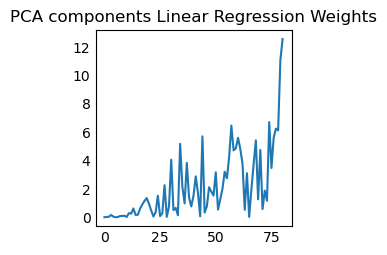

In [95]:
plt.plot([i for i in range(N_COMPONENTS)], abs(reg.coef_[0]))
# plt.plot([i for i in range(N_COMPONENTS)], abs(reg.coef_[0]))
plt.title(f"PCA components Linear Regression Weights")
plt.show()

In [ ]:
rf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=18,
    max_features=13,
    min_samples_split=3,
    min_samples_leaf=1,
    min_impurity_decrease=0.0,
    min_weight_fraction_leaf=0.0,
    random_state = 42,
)
rf.fit(train_X_reduced, train_y)
print("Training R^2:",round(rf.score(train_X_reduced,train_y),4))
print("Validation R^2:",round(rf.score(validate_X_reduced,validate_y),4))

Training R^2: 0.9497
Validation R^2: 0.662


In [15]:
# Original Regression
train_X, validate_X, train_y, validate_y = sklearn.model_selection.train_test_split(nr900to1700, fractions, test_size=TEST_SIZE, random_state=42)
reg = sklearn.linear_model.LinearRegression()
reg.fit(X=train_X,y=train_y)
print("Training R^2:",round(reg.score(train_X,train_y),4))
print("Validation R^2:",round(reg.score(validate_X,validate_y),4))

Training R^2: 0.8486
Validation R^2: 0.8165


In [133]:
# Manual Dimensional Reduction
nr950a1200a1500 = nr900to1700[['950','1200','1500']]
train_X, validate_X, train_y, validate_y = sklearn.model_selection.train_test_split(nr950a1200a1500, fractions, test_size=TEST_SIZE, random_state=42)
reg = sklearn.linear_model.LinearRegression()
reg.fit(X=train_X,y=train_y)
print("Training R^2:",round(reg.score(train_X,train_y),4))
print("Validation R^2:",round(reg.score(validate_X,validate_y),4))

Training R^2: 0.5422
Validation R^2: 0.5008
